# 뉴스기사 요약해보기

> **추상적 요약(Abstractive Summarization)**
<br> 원문으로부터 내용이 요약된 새로운 문장을 생성해낸다. 자연어 생성(NLG)의 영역이다.
<br><br> **추출적 요약(Extractive Summarization)**
<br> 원문에서 문장들을 추출해서 요약하는 방식이다. 문장 분류(Text Classification)의 영역이다.

## * 데이터 준비하기

In [1]:
# 다운로드한 뉴스 기사 데이터에서 불용어를 제거하기 위해 NTLK(Natural Language Toolkit) 불러오기
import nltk
nltk.download('stopwords')

# 모듈 불러오기
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 데이터 불러오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
# 데이터 확인하기
print('전체 샘플수 :', (len(data)))
data.sample(10)

전체 샘플수 : 98401


,headlines,text
31998,Russian hackers posed as ISIS to threaten US m...,Russian hackers operated under the name of 'IS...
31105,Lalu returns to jail after 5-day parole for so...,RJD chief Lalu Prasad Yadav on Monday returned...
59701,Indian-origin men among 4 dead in midair chopp...,An 18-year-old Indian-origin trainee pilot and...
55882,Lotuses in full bloom on Thai lake in annual p...,Lotuses of pink and red hues are in full bloom...
9642,"Sidhu open critic of Modi govt, needs CISF sec...",Congress spokesperson Randeep Surjewala has wr...
42302,Tiger was never supposed to shoot for our 2nd ...,Kapil Sharma has refuted rumours of Tiger Shro...
96618,Hot and cold water sound different when poured,Hot and cold water sound different when poured...
28557,Team loses despite needing 3 in 12 balls with ...,"Needing 189 to win in a 40-over match, English..."
51397,What is the Judge BH Loya death case?,"CBI Judge BH Loya, who was hearing the Sohrabu..."
10196,Tiger Global invests $3mn in US-based startup ...,American hedge fund Tiger Global Management ha...


이 데이터는 기사의 본문에 해당하는 text와 headlines 두 가지 열로 구성되어있다.
<br> 추상적 요약을 할 때는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 예정이고, 추출적 요약을 할 때는 text열만 사용할 예정이다.

---

## < 추상적 요약 >

## Step 1. 데이터 전처리하기

### 1) 데이터 정리하기

#### 중복 샘플과 NULL 값이 존재하는 샘플 제거

빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목 등
<br> 학습할 때 방해가 되는 데이터 먼저 솎아내보자.

In [4]:
# 데이터의 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


text가 달라도 headlines는 동일할 수 있다. (같은 내용이지만 다른 기사)
<br> text 자체가 중복된 경우는 중복 샘플이니 제거해야 한다.

In [5]:
# drop_duplicates()으로 손쉽게 중복 샘플 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿈
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
# Null값 남아있는지 확인하기
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


#### 텍스트 정규화와 불용어 제거

>**텍스트 정규화**(Text normalization) : 같은 의미인데도 다른 표현으로 쓰여서 마치 다른 단어들처럼 간주되는 경우에서 같은 표현으로 통일시켜주는 방법
<br> 기계의 연산량을 줄일 수 있다.
<br> (it'll = it will,  mustn't = must not 등과 같은 것) <br>
[텍스트 정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [7]:
# 텍스트 정규화를 위한 사전 구성

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines) - Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines에는 남아 있는 게 더 좋을 듯
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

훈련 데이터 전체에 대해서 전처리 수행해보자.
<br> text는 불용어를 제거하고, headlines는 불용어를 제거하지 않기 위해 따로 호출해서 진행한다.

In [10]:
clean_text = []
# 전체 text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))  # 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣음

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장해주자. 빈 값을 가진 샘플들은 모두 Null 값을 가진 샘플로 대체해준다.

In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

Null 값 생겼는지 확인해보자.

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 2) 훈련데이터와 테스트데이터 나누기

학습 진행 위해서는 학습에 사용할 데이터 크기를 결정하고, 문장의 시작과 끝을 표시해줘야 한다.

#### 샘플 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


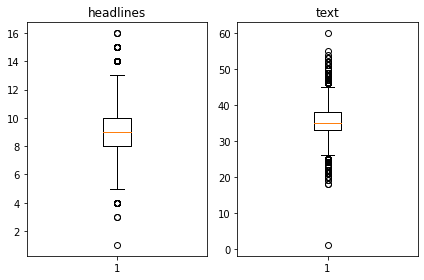

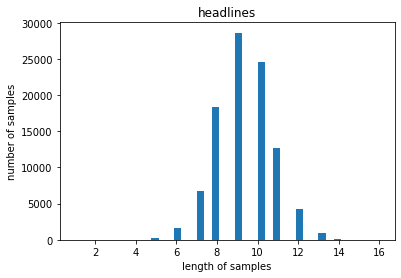

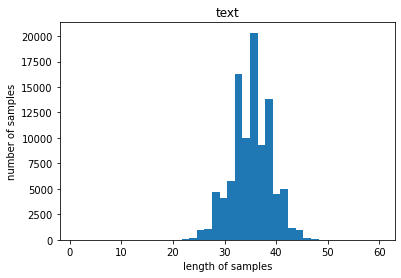

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있다.
<br> text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해보자.

In [15]:
text_max_len = 45
headlines_max_len = 13

이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인해보는 것이 길이를 결정하는 데에 도움이 될 것이다. 
<br> 훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당되는지 계산되는 함수를 만들어보자.

In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
# text에 적용해보기
below_threshold_len(text_max_len, data['text'])

# headlines에 적용해보기
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


정해진 길이보다 길면 제외하는 방법으로 데이터를 정제한다.

In [18]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 97863


#### 시작 토큰과 종료 토큰 추가하기

디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춘다. 훈련을 위해 앞 뒤로 추가해보자.
<br> 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input,
<br> 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target으로 정한다.
<br> 두 개의 문장 모두 headlines열로부터 만들 예정이다.

In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해준다.

In [20]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 훈련 데이터와 테스트 데이터 분리
분리 패키지를 사용하는 방법이 있지만 여기서는 직접 코딩을 통해 분리해보자.

In [21]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 5168 80805 90896 ... 53147  5014 77936]


In [22]:
# 위의 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 됨
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
# 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리하기 위해 테스트 데이터의 크기 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19572


In [24]:
# 정의한 테스트 데이터의 개수 이용해서 전체 데이터 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


### 3) 정수 인코딩

#### 단어 집합 만들기

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꿔줘야 한다. <br>각 단어에 고유한 정수를 맵핑하는 작업을 단어 집합을 만든다고 표현한다.

In [25]:
# Keras의 토크나이저를 사용하면 입력된 훈련데이터로부터 단어 집합을 만들 수 있음
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

빈도 수가 낮은 단어를 훈련데이터에서 제외한다.

In [26]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69223
등장 빈도가 6번 이하인 희귀 단어의 수: 47135
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22088
단어 집합에서 희귀 단어의 비율: 68.09153027173049
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.48697542221892


In [27]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[1880, 76, 14257, 2615, 61, 97, 18, 959, 144, 62, 897, 14720, 675, 21, 214, 17379, 4986, 959, 570, 675, 8508, 462, 2287, 127, 6604, 18326, 6769, 959, 667, 462, 3, 76, 14257, 2615, 1], [712, 11769, 13740, 96, 358, 572, 379, 2302, 768, 727, 296, 1797, 4050, 115, 39, 11769, 1112, 305, 712, 13740, 1218, 436, 13740, 173, 186, 436, 572, 1314, 11769, 7134, 1385, 13740, 96, 1288, 43, 2302, 768], [372, 392, 750, 5740, 8001, 5906, 790, 203, 1160, 8381, 629, 414, 2328, 117, 8381, 1577, 33, 396, 228, 415, 4257, 379, 5526, 558, 415, 3360, 1160, 287, 166, 365, 465]]


headlines에 대해서 동일한 작업 수행해준다.

In [29]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29995
등장 빈도가 5번 이하인 희귀 단어의 수: 19609
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10386
단어 집합에서 희귀 단어의 비율: 65.37422903817303
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.662663325999253


In [31]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1616, 34, 422, 53, 1281, 5, 510], [1, 6793, 396, 112, 5637, 25, 3, 7, 2393, 1384], [1, 891, 743, 1586, 5, 8786, 17, 238], [1, 38, 1138, 302, 11, 114, 2842, 17, 197, 4, 25], [1, 8, 3, 119, 80, 487, 3235, 3, 18, 683, 392, 40]]
target
decoder  [[1616, 34, 422, 53, 1281, 5, 510, 2], [6793, 396, 112, 5637, 25, 3, 7, 2393, 1384, 2], [891, 743, 1586, 5, 8786, 17, 238, 2], [38, 1138, 302, 11, 114, 2842, 17, 197, 4, 25, 2], [8, 3, 119, 80, 487, 3235, 3, 18, 683, 392, 40, 2]]


요약문의 길이가 1인 경우(토큰만 남아있는 경우) 삭제해준다.

In [32]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19571
테스트 레이블의 개수 : 19571


#### 패딩해주기

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

---

## Step 2. 어텐션 메커니즘 사용하기

### 1) 어텐션 메커니즘 seq2seq 모델 설계하기

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [38]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 2) 모델 훈련하기

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기종료 : 특정 조건이 충족되면 훈련을 멈춤
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 202s 632ms/step - loss: 5.2351 - val_loss: 4.7980
Epoch 2/50
306/306 [==============================] - 193s 631ms/step - loss: 4.6546 - val_loss: 4.4377
Epoch 3/50
306/306 [==============================] - 193s 630ms/step - loss: 4.3514 - val_loss: 4.2146
Epoch 4/50
306/306 [==============================] - 193s 631ms/step - loss: 4.1185 - val_loss: 4.0491
Epoch 5/50
306/306 [==============================] - 193s 632ms/step - loss: 3.9290 - val_loss: 3.9067
Epoch 6/50
306/306 [==============================] - 193s 631ms/step - loss: 3.7729 - val_loss: 3.8082
Epoch 7/50
306/306 [==============================] - 194s 634ms/step - loss: 3.6395 - val_loss: 3.7244
Epoch 8/50
306/306 [==============================] - 193s 631ms/step - loss: 3.5238 - val_loss: 3.6532
Epoch 9/50
306/306 [==============================] - 193s 632ms/step - loss: 3.4226 - val_loss: 3.5953
Epoch 10/50
306/306 [==============================] - 194s 633m

훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화해본다.

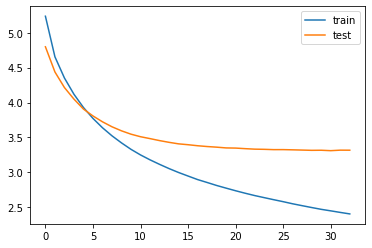

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 3) 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비한다.

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 인코더와 디코더가 분리된 모델 설계를 별도로 해주어야 한다. 

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들어준다.

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

---

## Step 3. 실제 결과와 요약문 비교하기

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [60]:
for i in range(10,20):
    print(i)
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 제목 :", seq2summary(decoder_input_test[i]))
    print("예측 제목 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

10
원문 : gujarat high court asked centre consider giving job sister indian man lodged pakistani jail since suspicions spy hc directed union ministry home affairs consider giving job within one month compassionate grounds exceptional case 
실제 제목 : consider giving job to kin of man jailed in pak hc to govt 
예측 제목 :  hc asks pak govt to bring back man who helped pak govt


11
원문 : late tv actress pratyusha banerjee last short film hum naa released first death anniversary saturday friend kamya punjabi film story reportedly bears similarities pratyusha life character named rahul said veiled reference boyfriend shot one half months pratyusha committed suicide 
실제 제목 : late actress pratyusha banerjee last short film released 
예측 제목 :  pratyusha to star in pratyusha on death anniversary


12
원문 : facebook rolling new feature called latest conversations search results show recent public posts people trending topics feature also includes live update counter showing many people talking topic one t

---

## < 추출적 요약 >

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다.

### 1) 데이터 다시 불러오기

In [50]:
from summa.summarizer import summarize

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
extdata = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### 2) Summa의 summarize() 사용하기

Summa의 summarize()의 인자로 사용되는 값들
>text (str) : 요약할 테스트.<br>
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값<br>
words (int or None, optional) – 출력에 포함할 단어 수.
<br>만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
<br>split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다.

In [70]:
for i in range(10, 20):
    print(i)
    print("원문 :", extdata['text'][i])
    print("실제 제목 :", extdata['headlines'][i])
    print("추출 제목 :", summarize(extdata['text'][i], ratio=0.5))
    print("\n")

10
원문 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.
실제 제목 : UP cousins fed human excreta for friendship with boys
추출 제목 : Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.


11
원문 : Isha Ghosh, an 81-year-old member of Bharat Scouts and Guides (BSG), has been imparting physical and mental training to schoolchildren in Jharkhand for several decades. Chaibasa-based Ghosh reportedly walks seven kilometres daily and spends eight hours conducting physical training, apart from climbing and yoga sessions. She says, "One should do something fo

---

## Abstractive / Extractive 요약 결과 비교해보기 + 회고

- 일단 전체적인 느낌을 보자면 추상적인 요약은 겉보기로는 요약이 잘된 것처럼 보인다. 실제 헤드라인들과 비교해봤을 때 문장 길이도 비슷하고 어투 또한 헤드라인처럼 느껴진다. 하지만 하나 하나 봤을 때는 그렇지 않다. 그나마 18번 혹은 19번 문장 정도가 비슷하게 요약된 것 같다. 그것도 비슷할 뿐이지 완전 잘된 것이라고는 볼 수 없다. 문법적으로 봤을 때 맞는 문장도 있고 맞지 않는 문장도 있지만 전체적으로 일단 핵심 단어를 어떻게 문법적으로 사용하는지를 모르는 느낌이라 아쉽다. 단어들을 잘 뽑은 문장도 있지만 주어로 가야할 단어가 이상한 위치로 가있거나, 주술 관계는 괜찮지만 엉뚱한 단어를 뽑아서 자리를 채워놨다든가 이런 실수들이 많다. 아마 학습데이터의 양과 학습 정도가 부족해서 그런 것 같은 느낌이 든다.
- 추출적 요약에 대해서는 일단 summarize의 인자로 ratio와 words를 써봤는데 ratio를 0.3으로 했을 때 위의 원문들을 하나도 요약하지 못하는 현상이 발생했다. ratio=0.4일 때 겨우 4개의 문장이 요약이 되었고, 그 수준은 그냥 위의 원문의 문장 중 하나를 가져다가 쓴 수준이었다. 추출적 요약은 문장들 중에서 추출을 하는 것이다보니 아예 똑같은 문장을 가져다가 쓰는 듯 싶었다. 때문에 문장 완성도나 핵심단어, 문법적인 측면에서는 추상적 요약보다 훨씬 낫지만, 헤드라인으로 요약하는 것을 바랐기 때문에 이건 제대로 요약하는 것이 아니라는 생각이 들었다. words는 위에서 headlines의 max_len이었던 13을 썼을 때 10개 중 3개의 문장이 요약되었다. 아무래도 headline처럼 문장을 요약하는 것이 아니라, 전체 원문 중 하나의 문장을 추출하는 것이다보니 13개의 단어로는 턱없이 부족한 것 같았다.
- 추상적 요약 과정에서 모델 훈련을 할 때 loss값이 높은 것이 눈에 밟혀서 하이퍼파라미터를 변경하거나 다른 시도를 해보고 싶었는데, 학습 시간이 너무 오래 걸려서 포기했다. 인코더와 디코더 등 모델을 쌓는 부분도 너무 어렵고, 데이터 전처리 과정도 너무 길다. 이러한 노력에 비해 결과물이 처참하니 NLP에 대해 정이 떨어지기 시작했다. 지난번에 노래 가사를 만들어내는 것이나 영화 리뷰 감성 분석을 할 때는 재밌었는데, 이번 노드는 재미도 느끼기 힘들었다. 아마 맛보기로 하기엔 너무 한계가 많은 과제가 아니었나 하는 생각이 든다. 다음에 기회가 된다면 정말 많은 양의 데이터와 제대로 된 학습, 그리고 완성도 높은 결과가 동반되는 NLP 과정을 경험해보고 싶다.